CS119 Big Data

Spring 2024

# Question 1-6 - Data Gathering

### Question 1-3 - Setup API account and load in api key

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!cp drive/MyDrive/Colab\ Notebooks/Quiz7/keys.py .
from keys import twelveDataKey as api_key

Mounted at /content/drive


### Question 4 - Set up data collection functions to gather data in format expected by df_hexdigest

In [3]:
import requests
import io
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time

def request_stock_data(ticker, start_date:datetime, end_date:datetime, interval='15min'):
  '''
  Query the API and return a df of the given ticker between the start_date and end_date
  '''
  url = 'https://api.twelvedata.com/time_series'
  params = {
      'symbol':ticker,
      'interval':interval,
      'start_date':start_date.strftime('%Y-%m-%d %H:%M:%S'),
      'end_date':end_date.strftime('%Y-%m-%d %H:%M:%S'),
      'apikey':api_key,
      'format':'CSV',
      'delimiter':',',
      'order':'ASC'
  }
  urlData = requests.get(url, params).content
  df = pd.read_csv(io.StringIO(urlData.decode('utf-8')),delimiter=',')
  df['Symbol'] = ticker
  return df

def collect_stock_data(tickers:list, start_date:datetime, end_date:datetime):
  '''
  Collects stock data for all of a list of tickers from start_date to present and returns as a single dataframe. Queries once every 10 seconds due to API provider limit of 8 requests per minute. Collects 26 weeks of data for a single ticker per query.
  '''
  # present = datetime.today()
  full_df = pd.DataFrame()
  interval_dfs = []
  for i, ticker in enumerate(tickers):
    interval_start = start_date
    while interval_start < end_date:
      interval_end = interval_start + timedelta(weeks=26)
      query_end = min(interval_end, end_date)
      print(f"Retrieving data for {ticker} from {interval_start.strftime('%Y-%m-%d %H:%M:%S')} to {query_end.strftime('%Y-%m-%d %H:%M:%S')}")
      interval_dfs.append(request_stock_data(ticker, interval_start, query_end))
      if i + 1 < len(tickers) or interval_end < end_date:
        print('Waiting 10s')
        time.sleep(10)
      interval_start = interval_end

  # Vertically concatenate list of dfs for each interval into one long df
  full_df = pd.concat(interval_dfs)
  return full_df

### Question 5-6 - Pull the stock data for AAPl, MSFT, and IBM at 15 minute intervals for four years (Jan 1 2020 to June 30 2024)

In [4]:
# Collect 4 years of data - Oct,1,2020 - present
# Using 8 AM so that it is clear that we do not collect duplicate timestamps - API only includes data during trading hours
stock_data_df = collect_stock_data(['AAPL', 'MSFT', 'IBM'], datetime(2020, 1, 1, 8), datetime(2024, 6, 30, 22))

Retrieving data for AAPL from 2020-01-01 08:00:00 to 2020-07-01 08:00:00
Waiting 10s
Retrieving data for AAPL from 2020-07-01 08:00:00 to 2020-12-30 08:00:00
Waiting 10s
Retrieving data for AAPL from 2020-12-30 08:00:00 to 2021-06-30 08:00:00
Waiting 10s
Retrieving data for AAPL from 2021-06-30 08:00:00 to 2021-12-29 08:00:00
Waiting 10s
Retrieving data for AAPL from 2021-12-29 08:00:00 to 2022-06-29 08:00:00
Waiting 10s
Retrieving data for AAPL from 2022-06-29 08:00:00 to 2022-12-28 08:00:00
Waiting 10s
Retrieving data for AAPL from 2022-12-28 08:00:00 to 2023-06-28 08:00:00
Waiting 10s
Retrieving data for AAPL from 2023-06-28 08:00:00 to 2023-12-27 08:00:00
Waiting 10s
Retrieving data for AAPL from 2023-12-27 08:00:00 to 2024-06-26 08:00:00
Waiting 10s
Retrieving data for AAPL from 2024-06-26 08:00:00 to 2024-06-30 22:00:00
Waiting 10s
Retrieving data for MSFT from 2020-01-01 08:00:00 to 2020-07-01 08:00:00
Waiting 10s
Retrieving data for MSFT from 2020-07-01 08:00:00 to 2020-12-30 0

In [5]:
def df_hexdigest(saved_df):
    '''
        saved_df should be a dataframe with columns ['datetime', 'open', 'high', 'low', 'close', 'volume', 'Symbol']
        and with all data points between 2020-01-01 and 2024-06-30 (both dates inclusive), for  AAPL, MSFT and IBM.
    '''

    # Convert 'datetime' column to datetime objects if it's not already
    import pandas as pd

    saved_df['datetime'] = pd.to_datetime(saved_df['datetime'])

    # Sort the DataFrame by the 'datetime' column
    saved_df = saved_df.sort_values('datetime')

    # Display the sorted DataFrame (optional)
    # print(saved_df)
    saved_df = saved_df.reset_index(drop=True)
    saved_df

    df_filtered = saved_df[(saved_df['datetime'] >= '2020-01-01') & (saved_df['datetime'] <= '2024-06-30')]
    df_filtered

    # Sort the DataFrame by the 'datetime' column
    df_filtered_sorted = df_filtered.sort_values('datetime')

    df_filtered_sorted = df_filtered_sorted.reset_index(drop=True)
    df_filtered_sorted.head()

    df_filtered_sorted_deduped = df_filtered_sorted.drop_duplicates(subset=['datetime', 'open', 'high', 'low', 'close', 'volume', 'Symbol'], keep='first')

    printed_string = df_filtered_sorted_deduped[['datetime', 'Symbol']].to_string(index=False, header=False)
    # print(printed_string[:2000])
    import hashlib
    md5_hash = hashlib.md5(printed_string.encode()) # Use hashlib.md5() to create the hash object
    return md5_hash.hexdigest()

In [9]:
stock_data_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Quiz7/stock_data.csv')
print(stock_data_df)

              datetime       open       high        low      close   volume  \
0  2020-01-02 15:45:00   75.06250   75.15000   74.97500   75.14760  5640128   
1  2020-01-03 09:45:00   74.99500   75.02000   74.65250   74.80040  9608768   
2  2020-01-03 10:00:00   74.79500   74.80000   74.40250   74.79185  8477900   
3  2020-01-03 10:15:00   74.79500   74.89585   74.69263   74.86750  4918860   
4  2020-01-03 10:30:00   74.86250   74.86750   74.56250   74.59753  3234384   
..                 ...        ...        ...        ...        ...      ...   
73 2024-06-28 14:45:00  172.24001  172.30499  172.07170  172.27000    57354   
74 2024-06-28 15:00:00  172.25000  172.30000  171.96750  172.22000   109143   
75 2024-06-28 15:15:00  172.21001  172.92000  172.16499  172.81000    70159   
76 2024-06-28 15:30:00  172.82001  173.24001  172.42999  173.07001   115046   
77 2024-06-28 15:45:00  173.10001  173.34000  172.77000  173.00999   428610   

   Symbol  
0    AAPL  
1    AAPL  
2    AAPL  
3  

In [7]:
# checking parameters to create correct hash
print(stock_data_df['Symbol'].unique())
print(min(stock_data_df['datetime']))
print(max(stock_data_df['datetime']))
print(stock_data_df.columns)

['AAPL' 'MSFT' 'IBM']
2020-01-02 11:45:00
2024-06-28 15:45:00
Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'Symbol'], dtype='object')


In [8]:
df_hash = df_hexdigest(stock_data_df)
print(df_hash)
with open('/content/drive/MyDrive/Colab Notebooks/Quiz7/df_hash.txt', 'wt', encoding='utf-8') as f:
  f.write(df_hash)

8bf3d7cac13198b7eb145af3754cef1c


# Algorithmic Stock Trading

## Question 7 - Order Splitting Execution

In order to best break the order into manageable chunks so that I could buy 1,000,000 shares without letting the market know, I would start by specifying the time interval over which it would be acceptable to buy - for example over 2-4 weeks would give much more flexibility than 1 day. If there is no rush, I would choose to do it over the course of 4 weeks.

I would also make sure to not choose a time period that overlaps with a quarter end, since I do not want to have to disclose my holdings while I am still executing my small orders.

Then, I could look for which times of the day are likely to have the most trading volume, bias my purchases towards happening at those times. Since those times have the most volume anyway, it will be less supsicious to happen then, and there is likely significant expected variance in trading volumes at those times.

I would determine the number of chunks and the size of each chunk (to nearest 100 shares) randomly via a probability distribution, generated from historical data of previous trades. This way the size of each trade will most closely match previous, typical trades and not be suspicious.

I would also split my order between the available exchanges that it is listed on such as the New York stock exchange and the Chicago Stock Exchange, again proportional to typical activity for each exchange.

I will not base my trading strategy on price, and buy more when the price goes down, since my primary objective is to minimize suspicion, and there is no way to no whether the price will continue going down or not.




## Question 8 - Detecting Stock Dumping

My strategy for detecting someone dumping a large quantity of stocks would be to first check for the most obvious types of dumping, where there are large individual sell orders. I would then check for individual times where activity is much higher than usual.

I could do this by training a machine learning model, perhaps a neural network, on previous stock trading data that is capable of predicting how much trading volume is expected at a given time period. I could train multiple models for a single stock, one for each different time period - for example expected trading over the previous 10 minutes, vs over previous 2 hours vs over 1 day vs over 1 week. Then, if actual results differ significantly than the models predictions, that would be an indication there is stock dumping, or some other unusual activity.

In practice, this would be very difficult if the seller is attempting to hide their activity. There will be little way to differentiate between stock dumping from an individual, vs. decreased market sentiment causing many people to want to sell their stock. As one way to attempt to correct for this, I would also monitor the news cycle to see if some the results from the neural network could be explained by recent news - if there was bearish news from the company recently, I would discard the conclusion that a sell must be stock dumping from an individual.

# Technical Analysis Of Stock Trading

## Question 9-10 - Update stock-price-feeder.py

### new-stock-price-feeder.py

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# !pip install pandas
import pandas as pd
import time, datetime, sys
import os, pathlib
from keys import twelveDataKey as api_key

import requests
import io
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time

def request_stock_data(ticker, start_date:datetime, end_date:datetime, interval='15min'):
  '''
  Query the API and return a df of the open price of a given ticker between the start_date and end_date
  '''
  url = 'https://api.twelvedata.com/time_series'
  params = {
      'symbol':ticker,
      'interval':interval,
      'start_date':start_date.strftime('%Y-%m-%d %H:%M:%S'),
      'end_date':end_date.strftime('%Y-%m-%d %H:%M:%S'),
      'apikey':api_key,
      'format':'CSV',
      'delimiter':',',
      'order':'ASC'
  }
  urlData = requests.get(url, params).content
  df = pd.read_csv(io.StringIO(urlData.decode('utf-8')),delimiter=',', index_col='datetime')
  df.drop(columns=['high','low','close','volume'], inplace=True)
  df.rename(columns={'open':ticker}, inplace=True)
  return df

def collect_stock_data_new(tickers:list, start_date:datetime):
  '''
  Collects up to 5,000 days of stock data for all of a list of tickers from start_date and returns as a single dataframe. If more than 8 tickers, only queries every 60 seconds due to API provider limit of 8 requests per minute.
  '''
  full_df = pd.DataFrame()
  for i, ticker in enumerate(tickers):
    interval_end = start_date + timedelta(days=5000)
    ticker_df = request_stock_data(ticker, start_date, interval_end, interval='1day')
    if (i+1) % 8 == 0:
      print('Waiting 60s')
      time.sleep(60)
    if full_df.empty:
      full_df = ticker_df
    else:
      full_df = full_df.join(ticker_df)
  return full_df

tech_df = collect_stock_data_new(['AAPL', 'MSFT'], datetime(2024, 6, 1, 8))

sys.stdout.reconfigure(encoding='utf-8')
sys.path.insert(0, str(pathlib.Path(__file__).parent.parent))

dates = tech_df.index.rename('Date')
init_date = list(dates)[0]
last_hist_date = list(dates)[-1]


init_delay_seconds = 30
interval = 5

scaler = tech_df['AAPL'][init_date]/tech_df['MSFT'][init_date]
aapl  = tech_df['AAPL']
msft  = tech_df['MSFT']
tech_df['scaledMSFT'] = msft*scaler

print ('Sending daily AAPL and MSFT prices from %10s to %10s ...' % (str(init_date)[:10], str(last_hist_date)[:10]), flush=True, file=sys.stderr)
print ("... each day's data sent every %d seconds ..." % (interval), flush=True, file=sys.stderr)
print ('... beginning in %02d seconds ...' % (init_delay_seconds), flush=True, file=sys.stderr)
print ("... MSFT prices adjusted to match AAPL prices on %10s ..."  % (init_date), flush=True, file=sys.stderr)

from tqdm import tqdm
for left in tqdm(range(init_delay_seconds)):
    time.sleep(0.5)

for date in list(dates):       
    print ('%10s\t%.4f\t%.4f' % (str(date)[:10], tech_df['AAPL'][date], tech_df['scaledMSFT'][date]), flush=True)
    time.sleep(float(interval))

exit(0)

## Question 11-14 - Create pyspark streams for comparing moving averages, and executing buy/sell trades

Run with:

In sender: python new-stock-price-feeder.py 2>/dev/null | nc -lk 9999

In receiver: spark-submit q3-stock-streaming.py localhost 9999

Example results:

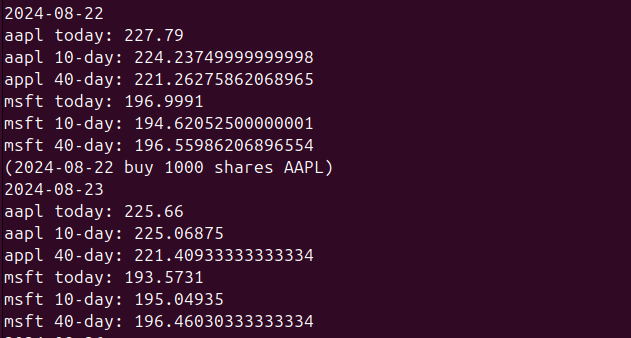

### Pyspark Code: q3-stock-streaming.py

In [ ]:
import sys, time

import pyspark
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql.functions import window, avg,  col

def setLogLevel(sc, level):
    from pyspark.sql import SparkSession
    spark = SparkSession(sc)
    spark.sparkContext.setLogLevel(level)

if __name__ == "__main__":
    if len(sys.argv) != 3:
        print("Usage: q3-stock-streaming.py <hostname> <port>", file=sys.stderr)
        sys.exit(-1)

    print ('Argv', sys.argv)
    
    host = sys.argv[1]
    port = int(sys.argv[2])
    print ('host', type(host), host, 'port', type(port), port)

    sc_bak = SparkContext.getOrCreate()
    sc_bak.stop()
    
    time.sleep(15)
    print ('Ready to work!')

    ctx = pyspark.SparkContext(appName = "Stock Streaming", master="local[*]")
    print ('Context', ctx)

    spark = SparkSession(ctx).builder.getOrCreate()
    sc = spark.sparkContext

    setLogLevel(sc, "WARN")

    print ('Session:', spark)
    print ('SparkContext', sc)
    

    # Create DataFrame representing the stream of input lines from connection to host:port
    lines = spark\
        .readStream\
        .format('socket')\
        .option('host', host)\
        .option('port', port)\
        .load()

    # Question 11
    aaplPrice = lines.selectExpr("split(value, '\t') as col").selectExpr("cast(col[0] as timestamp) as timestamp", "cast(col[1] as double) as AAPL").withWatermark("timestamp", "40 days")

    msftPrice = lines.selectExpr("split(value, '\t') as col").selectExpr("cast(col[0] as timestamp) as timestamp", "cast(col[2] as double) as MSFT").withWatermark("timestamp", "40 days")

    # Question 12
    # Also need 1 day prices so we can calculate the equiv number of MSFT shares to 1,000 shares of AAPL
    aapl1Day = aaplPrice\
        .groupBy(window(col("timestamp"), "1 day", "1 day"))\
        .agg(avg(col("AAPL")).alias("rolling_avg_appl_1"))\
        .selectExpr("window.end as window_end", "rolling_avg_appl_1")

    aapl10Day = aaplPrice\
        .groupBy(window(col("timestamp"), "10 days", "1 day"))\
        .agg(avg(col("AAPL")).alias("rolling_avg_appl_10"))\
        .selectExpr("window.end as window_end", "rolling_avg_appl_10")
    
    aapl40Day = aaplPrice\
        .groupBy(window(col("timestamp"), "40 days", "1 day"))\
        .agg(avg(col("AAPL")).alias("rolling_avg_appl_40"))\
        .selectExpr("window.end as window_end", "rolling_avg_appl_40")
    
    # Question 13
    msft1Day = msftPrice\
        .groupBy(window(col("timestamp"), "1 day", "1 day"))\
        .agg(avg(col("MSFT")).alias("rolling_avg_msft_1"))\
        .selectExpr("window.end as window_end", "rolling_avg_msft_1")

    msft10Day = msftPrice\
        .groupBy(window(col("timestamp"), "10 days", "1 day"))\
        .agg(avg(col("MSFT")).alias("rolling_avg_msft_10"))\
        .selectExpr("window.end as window_end", "rolling_avg_msft_10")
    
    msft40Day = msftPrice\
        .groupBy(window(col("timestamp"), "40 days", "1 day"))\
        .agg(avg(col("MSFT")).alias("rolling_avg_msft_40"))\
        .selectExpr("window.end as window_end", "rolling_avg_msft_40")

    # Question 14
    # Join on window_end since that is the "current day" to buy or sell on
    joined_streams = aapl1Day\
        .join(aapl10Day, "window_end")\
        .join(aapl40Day, "window_end")\
        .join(msft1Day, "window_end")\
        .join(msft10Day, "window_end")\
        .join(msft40Day, "window_end")\

    with open("trade_signals.txt", "w") as file:
        file.write("[")

    def print_to_file(text:str):
        filename = "trade_signals.txt"
        with open(filename, "a") as file:
            file.write(text + ",")
            
    previous_df = None
    def compare_and_print(batch_df, batch_id):
        '''
        Compare the rolling averages and print the result to file and console. Print extra info to console to monitor status of stream.
        '''
        output_file = ""
        global previous_df
        current_df = batch_df.collect()
        if previous_df is not None:
            for current, previous in zip(current_df, previous_df):
                date = current["window_end"].date()
                print(date)
                print(f'aapl today: {current["rolling_avg_appl_1"]}')
                print(f'aapl 10-day: {current["rolling_avg_appl_10"]}')
                print(f'appl 40-day: {current["rolling_avg_appl_40"]}')

                print(f'msft today: {current["rolling_avg_msft_1"]}')
                print(f'msft 10-day: {current["rolling_avg_msft_10"]}')
                print(f'msft 40-day: {current["rolling_avg_msft_40"]}')
                
                previous_buy_appl = (previous["rolling_avg_appl_10"] > previous["rolling_avg_appl_40"])
                current_buy_appl = (current["rolling_avg_appl_10"] > current["rolling_avg_appl_40"])

                previous_buy_msft = (previous["rolling_avg_msft_10"] > previous["rolling_avg_msft_40"])
                current_buy_msft = (current["rolling_avg_msft_10"] > current["rolling_avg_msft_40"])

                if (previous_buy_appl and not current_buy_appl):
                    print(f'({date} sell 1000 shares AAPL)')
                    print_to_file(f'({date} sell 1000 shares AAPL)')
                elif (current_buy_appl and not previous_buy_appl):
                    print(f'({date} buy 1000 shares AAPL)')
                    print_to_file(f'({date} buy 1000 shares AAPL)')

                # Number of msft shares that are same dollar amount as 1,000 aapl shares
                msft_equiv_shares = 1000*current["rolling_avg_appl_1"]/current["rolling_avg_msft_1"]
                if (previous_buy_msft and not current_buy_msft):
                    print(f'({date} sell {msft_equiv_shares:.2f} shares MSFT)')
                    print_to_file(f'({date} sell {msft_equiv_shares:.2f} shares MSFT)')
                elif (current_buy_msft and not previous_buy_msft):
                    print(f'({date} buy {msft_equiv_shares:.2f} shares MSFT)')
                    print_to_file(f'({date} buy {msft_equiv_shares:.2f} shares MSFT)')

        previous_df = current_df

    query = joined_streams.writeStream\
        .foreachBatch(compare_and_print)\
        .start()

    query.awaitTermination()

    with open("trade_signals.txt", "a") as file:
        file.write("]")

### Results: trade_signals.txt - For time period of June 2024 - October 2024

[(2024-06-14 buy 1000 shares AAPL),(2024-06-14 buy 1051.06 shares MSFT),(2024-06-13 buy 1000 shares AAPL),(2024-06-13 buy 1049.28 shares MSFT),(2024-06-21 buy 1000 shares AAPL),(2024-06-21 buy 1013.02 shares MSFT),(2024-06-20 buy 1000 shares AAPL),(2024-06-20 buy 1032.56 shares MSFT),(2024-07-30 sell 1000 shares AAPL),(2024-07-30 sell 1103.90 shares MSFT),(2024-07-26 sell 1126.51 shares MSFT),(2024-07-25 sell 1099.82 shares MSFT),(2024-07-24 sell 1095.52 shares MSFT),(2024-07-22 sell 1106.88 shares MSFT),(2024-08-01 sell 1000 shares AAPL),(2024-08-02 sell 1000 shares AAPL),(2024-08-06 sell 1000 shares AAPL),(2024-08-05 sell 1000 shares AAPL),(2024-08-21 buy 1000 shares AAPL),(2024-08-19 buy 1000 shares AAPL),(2024-08-20 buy 1000 shares AAPL),(2024-08-27 buy 1000 shares AAPL),(2024-08-27 buy 1179.17 shares MSFT),(2024-08-22 buy 1000 shares AAPL),(2024-08-26 buy 1173.16 shares MSFT),(2024-08-28 buy 1183.40 shares MSFT),(2024-09-03 buy 1178.06 shares MSFT),(2024-08-30 sell 1193.11 shares MSFT),(2024-09-06 sell 1179.33 shares MSFT),(2024-09-09 sell 1168.04 shares MSFT),(2024-09-04 sell 1176.33 shares MSFT),(2024-09-16 sell 1000 shares AAPL),(2024-09-16 buy 1083.26 shares MSFT),(2024-09-17 sell 1000 shares AAPL),(2024-09-17 buy 1055.70 shares MSFT),(2024-09-18 sell 1000 shares AAPL),(2024-09-18 buy 1077.31 shares MSFT),(2024-09-27 buy 1000 shares AAPL),(2024-09-30 buy 1000 shares AAPL),(2024-10-01 buy 1000 shares AAPL),